# 使用PCA对人脸图片进行处理

此部分作业要求使用PCA技术对给定的人脸数据集进行处理，你需要在该文件中完成你的代码，并输出结果。



本次使用到的人脸数据集是 ORL人脸数据集，共包含40个不同人的400张图像。此数据集下包含40个目录，每个目录下有10张图像，每个目录表示一个不同的人。所有的图像是以PGM格式存储，灰度图，图像大小宽度为92，高度为112。



数据集中部分图像示例：

![image-20230428112024592](./faces.png)



在本次作业中，你需要**按顺序**完成以下内容并且在该文件中**保留要求**的输出结果：

1. 将数据集划分为80%的训练集，20%的测试集，在训练集上使用PCA将特征维度降为100，即得到100个特征和其对应的特征向量，并使用训练得到的PCA将测试集维度也压缩到100，**输出：压缩后的训练集维度和测试集维度、经过PCA得到的特征向量维度**。

2. 得到100个特征向量后，**使用这些向量重建特征脸并输出**。示例：

   ![image2](./feature.png)

3. 使用这100个特征和对应的特征向量，自行在训练集和测试集中**分别**选择**5张**人脸图片进行人脸重建并**输出对比图**。示例：

   ![image2](./restore.png)

4. **输出**降维后**每个**新特征向量所占的信息量占原始数据总信息量的百分比，以及所有返回特征所携带的**信息量总和**是原始数据的多少；

5. **画出**特征个数和所携带信息数的曲线图，此处特征数**上限设置为150**，此处以150为示例：

   ![image2](./information.png)

6.  保留特征数为150，得到的训练集每次保留前（n=n+1，n初值为1）个特征，分别训练一个KNN分类器，KNN分类器的参数*n_neighbors*为3，观察并验证测试集在使用其前n个特征时KNN分类的准确率。**注意：此处仅进行一次PCA**,输出：不同的特征保留数和准确率的曲线图。此处以*n_neighbors=5*为示例：

   ![image2](./acc.png)

   **本次作业严禁抄袭，一经发现严肃处理**


#  附加题

若感兴趣，可以自行拍摄自己或舍友的人脸照片、或者其他较为简单且特征明显的数据集进行PCA操作。


In [1]:
# 本次作业你可能需要用到的包和函数

%matplotlib inline
# 导入所需模块
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# plt显示灰度图片
def plt_show(img):
    plt.imshow(img,cmap='gray')
    plt.show()

# 读取一个文件夹下的所有图片，输入参数是文件名，返回文件地址列表
def read_directory(directory_name):
    faces_addr = []
    for filename in os.listdir(directory_name):
        faces_addr.append(directory_name + "/" + filename)
    return faces_addr

In [ ]:
# Your Code Here
def load_orl_dataset(root_dir):
    data = []
    labels = []
    dir_path_list = read_directory(root_dir)
    cnt = 0
    for dir_path in dir_path_list:
        if not os.path.exists(dir_path):
            print(f"警告：目录 {dir_path} 不存在")
            continue
        cnt = cnt + 1
        img_paths = read_directory(dir_path)
        for path in img_paths:
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                data.append(img.flatten())
                labels.append(cnt - 1)  # indice begin with 0
            else:
                print(f"警告：无法读取图像 {path}")
    return np.array(data), np.array(labels)

In [ ]:
data_path = "./data"  # root directory
data, labels = load_orl_dataset(data_path)

X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size = 0.2, stratify = labels, random_state = 42
)

pca = PCA(n_components = 100)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
print("压缩后训练集维度:", X_train_pca.shape)
print("压缩后测试集维度:", X_test_pca.shape)
print("经过PCA得到的特征向量维度:", pca.components_.shape)

压缩后训练集维度: (320, 100)
压缩后测试集维度: (80, 100)
经过PCA得到的特征向量维度: (100, 10304)


In [ ]:
def show_all_eigenfaces(eigenfaces, figsize = (30, 30)):

    plt.figure(figsize = figsize)
    
    rows, cols = 10, 10

    plt.subplots_adjust(
        left = 0.02, 
        right = 0.98, 
        bottom = 0.02, 
        top = 0.98, 
        wspace = 0.05, 
        hspace = 0.05
    )
    
    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(eigenfaces[i], cmap = 'gray')
        plt.axis('off')
    
    plt.suptitle("All 100 Eigenfaces (1-100)", y = 0.999, fontsize = 20)
    plt.show()

使用这些向量重建的特征脸:


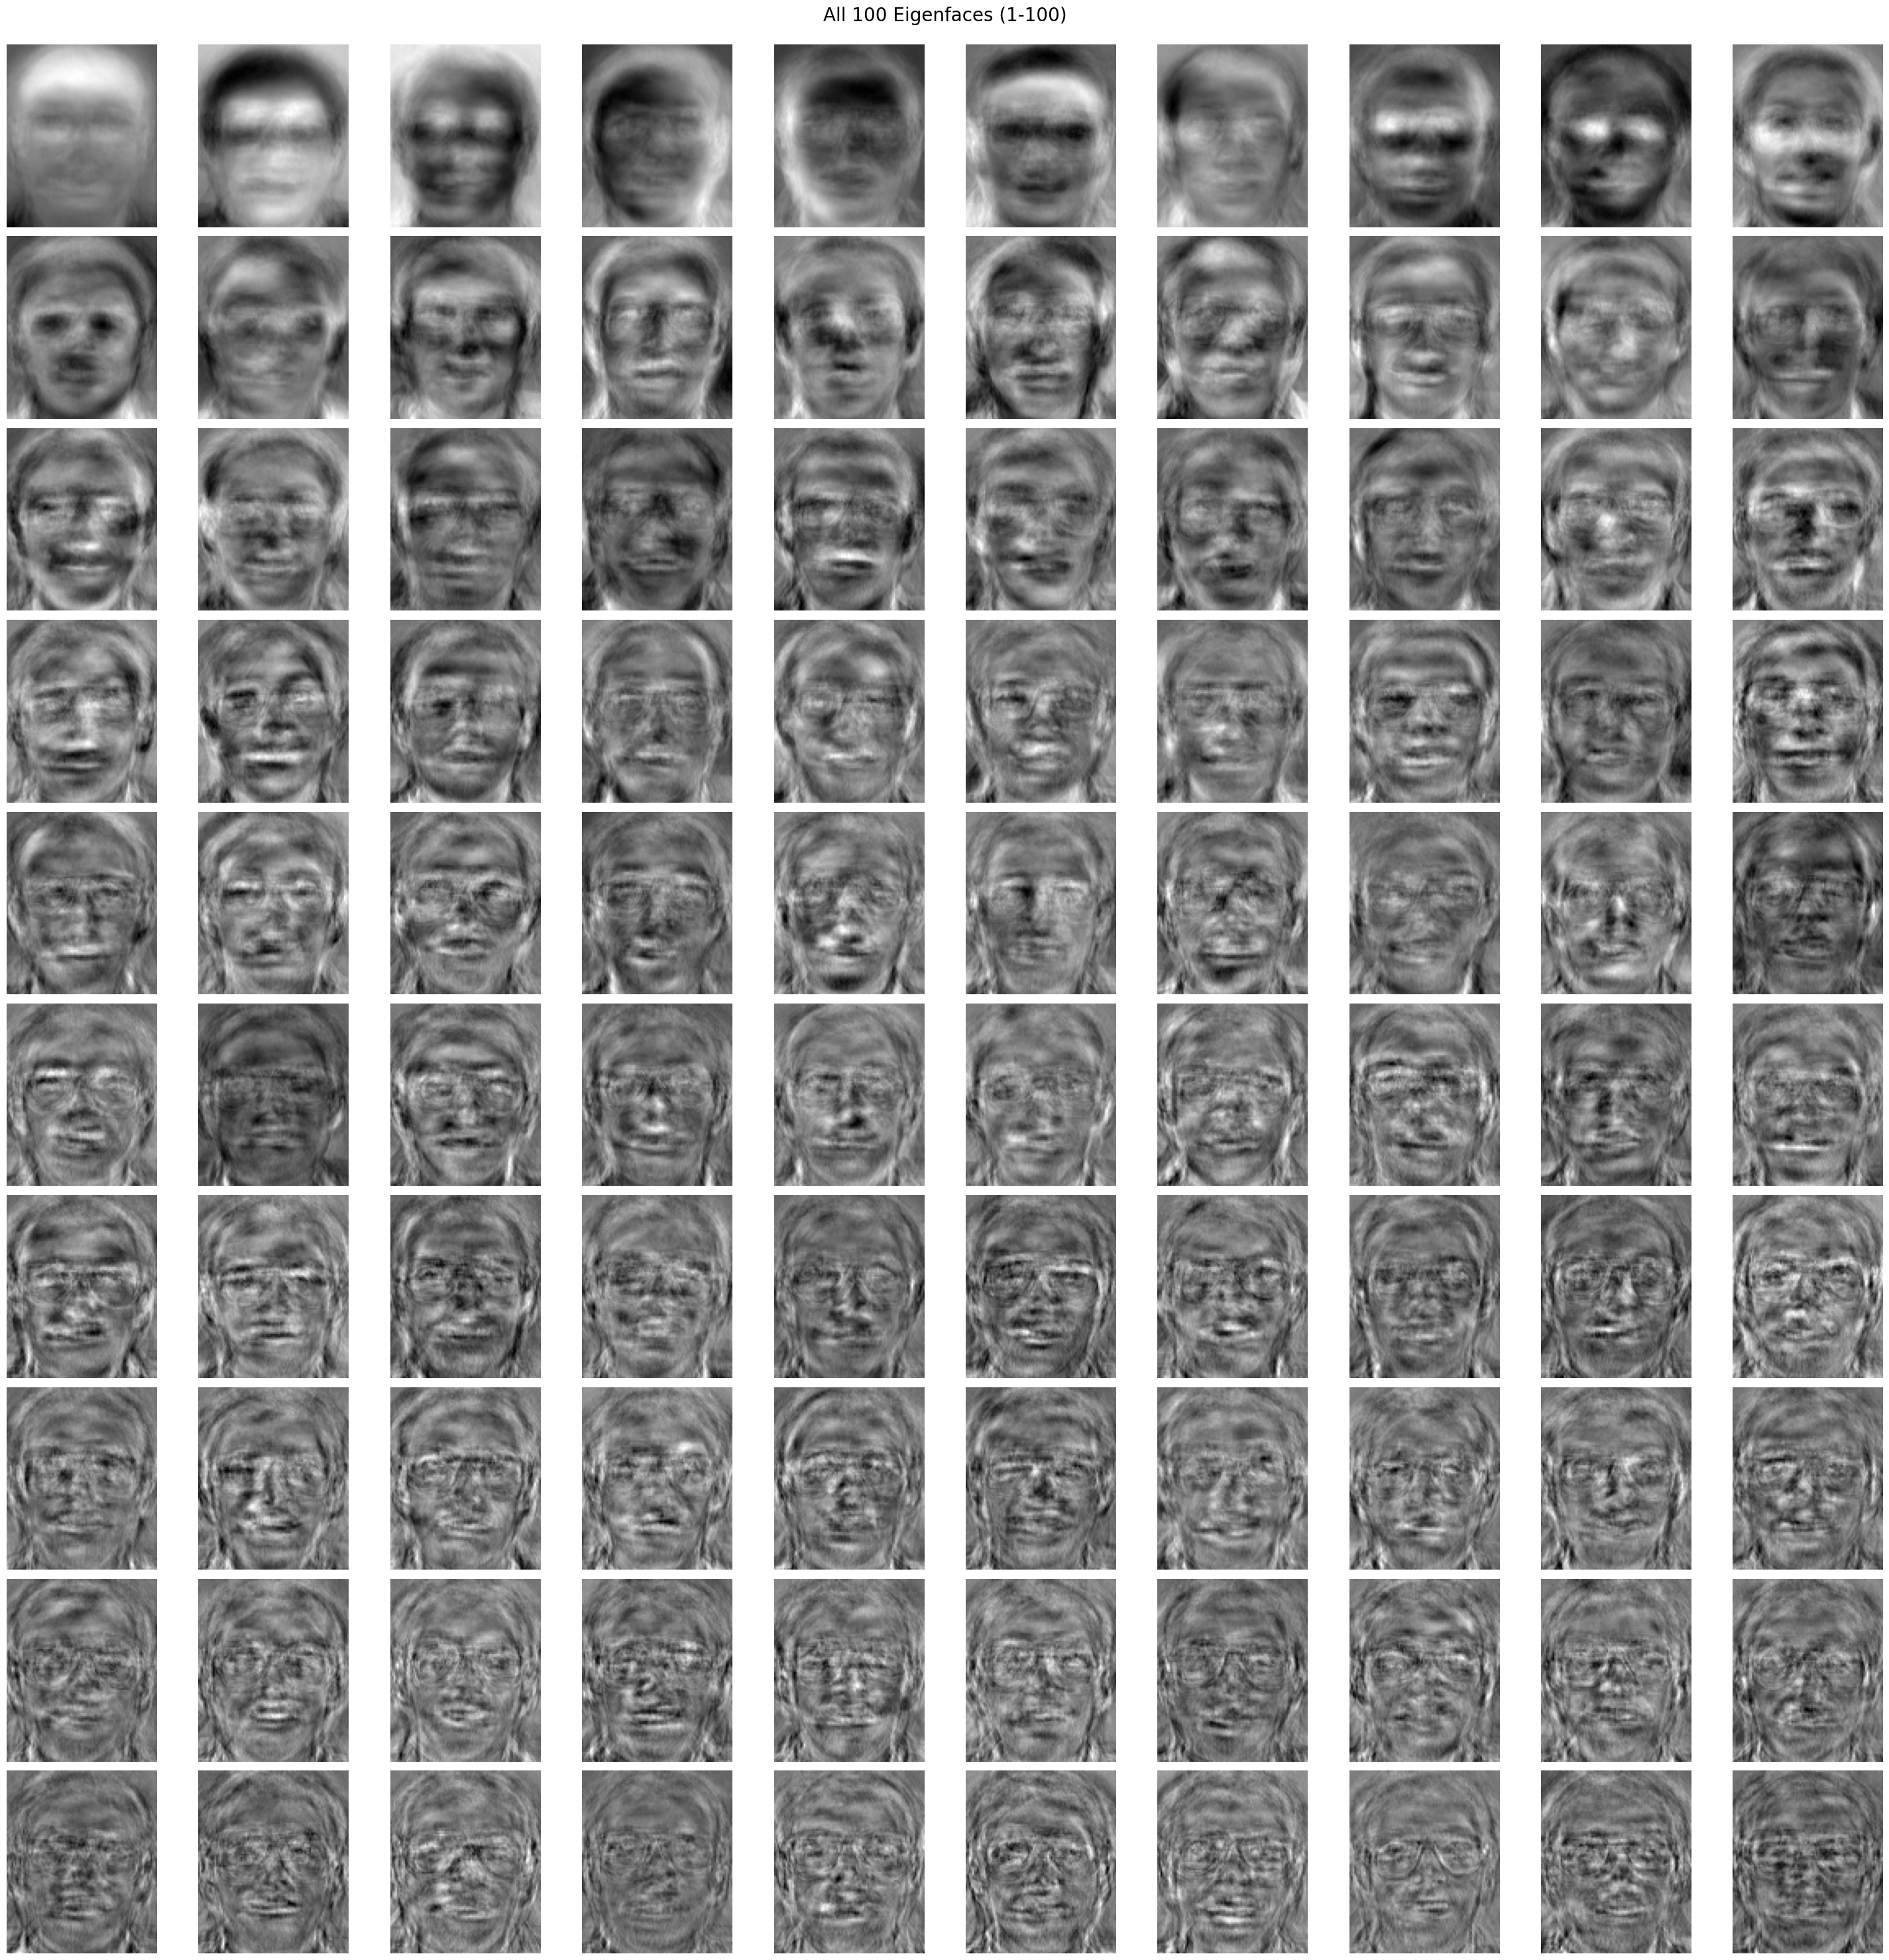

In [5]:
eigenfaces = pca.components_.reshape(100, 112, 92)
print("使用这些向量重建的特征脸:")
show_all_eigenfaces(eigenfaces)

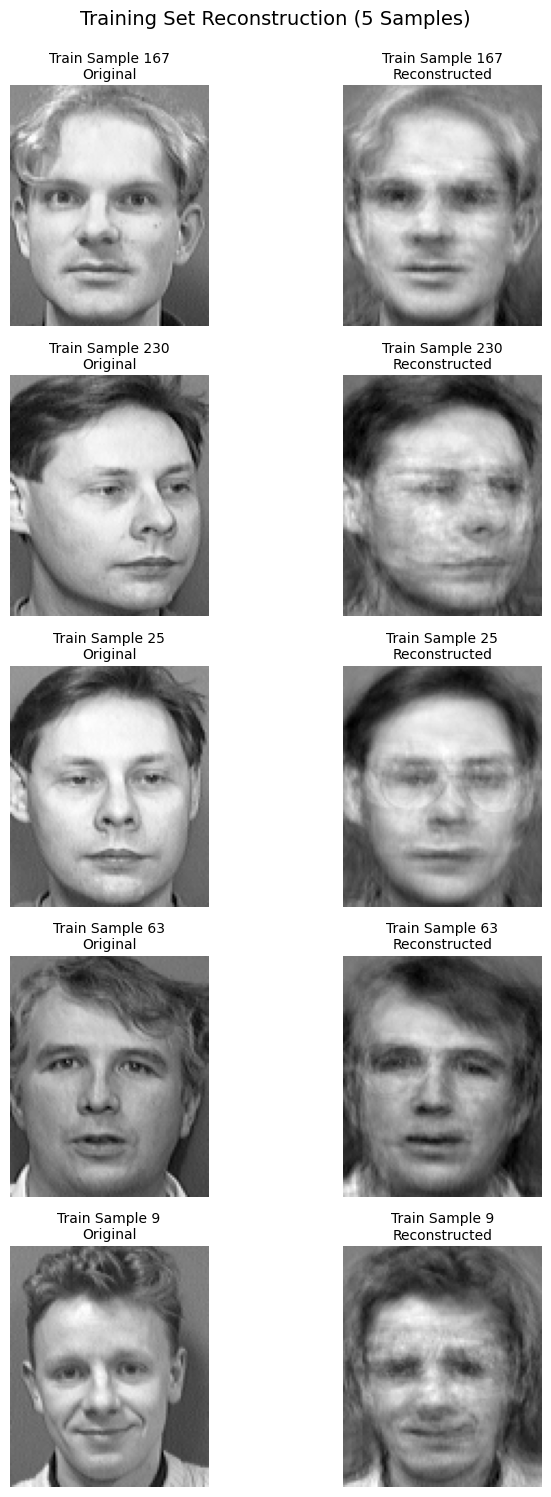

In [ ]:
np.random.seed(42)
train_indices = np.random.choice(X_train.shape[0], 5, replace = False)
reconstructed_train = pca.inverse_transform(X_train_pca)

plt.figure(figsize = (8, 15))  # 调整画布尺寸适应垂直布局
for i, idx in enumerate(train_indices):
    # Original
    plt.subplot(5, 2, 2 * i + 1)
    plt.imshow(X_train[idx].reshape(112, 92), cmap = 'gray')
    plt.title(f"Train Sample {idx}\nOriginal", fontsize = 10, pad = 5)
    plt.axis('off')
    
    # Reconstructed
    plt.subplot(5, 2, 2 * i + 2)
    plt.imshow(reconstructed_train[idx].reshape(112, 92), cmap = 'gray')
    plt.title(f"Train Sample {idx}\nReconstructed", fontsize = 10, pad = 5)
    plt.axis('off')

plt.suptitle("Training Set Reconstruction (5 Samples)", y = 0.995, fontsize = 14)
plt.tight_layout()
plt.show()

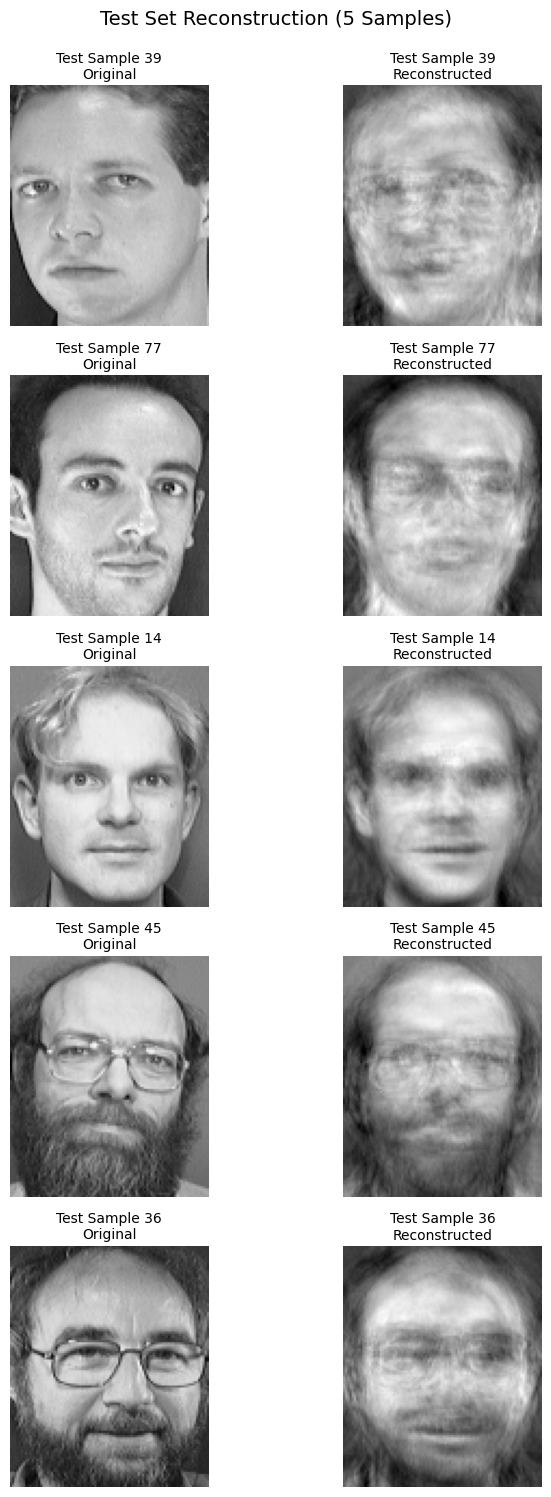

In [ ]:
np.random.seed(24)
test_indices = np.random.choice(X_test.shape[0], 5, replace=False)
reconstructed_test = pca.inverse_transform(X_test_pca)

plt.figure(figsize = (8, 15))
for i, idx in enumerate(test_indices):
    # Original
    plt.subplot(5, 2, 2 * i + 1)
    plt.imshow(X_test[idx].reshape(112, 92), cmap = 'gray')
    plt.title(f"Test Sample {idx}\nOriginal", fontsize = 10, pad = 5)
    plt.axis('off')
    
    # Reconstructed
    plt.subplot(5, 2, 2 * i + 2)
    plt.imshow(reconstructed_test[idx].reshape(112, 92), cmap = 'gray')
    plt.title(f"Test Sample {idx}\nReconstructed", fontsize = 10, pad = 5)
    plt.axis('off')

plt.suptitle("Test Set Reconstruction (5 Samples)", y = 0.995, fontsize = 14)
plt.tight_layout()
plt.show()

In [8]:
print("\n降维后每个新特征向量所占的信息量占原始数据总信息量的百分比：")
for comp_idx, ratio in enumerate(pca.explained_variance_ratio_, 1):
    print(f"  主成分 {comp_idx:1d}: {ratio * 100:.4f}%")

cumulative_total = np.sum(pca.explained_variance_ratio_)
print(f"\n所有返回特征所携带的信息量总和占原始数据的比例：")
print(f"  {cumulative_total * 100:.4f}%")


降维后每个新特征向量所占的信息量占原始数据总信息量的百分比：
  主成分 1: 17.4951%
  主成分 2: 12.8885%
  主成分 3: 7.0003%
  主成分 4: 5.5752%
  主成分 5: 5.1780%
  主成分 6: 3.3613%
  主成分 7: 2.5024%
  主成分 8: 2.3152%
  主成分 9: 1.9931%
  主成分 10: 1.8486%
  主成分 11: 1.4713%
  主成分 12: 1.3445%
  主成分 13: 1.1886%
  主成分 14: 1.0686%
  主成分 15: 0.9999%
  主成分 16: 0.9568%
  主成分 17: 0.9201%
  主成分 18: 0.8724%
  主成分 19: 0.7572%
  主成分 20: 0.6984%
  主成分 21: 0.6707%
  主成分 22: 0.6390%
  主成分 23: 0.5960%
  主成分 24: 0.5874%
  主成分 25: 0.5472%
  主成分 26: 0.5329%
  主成分 27: 0.5175%
  主成分 28: 0.4990%
  主成分 29: 0.4757%
  主成分 30: 0.4413%
  主成分 31: 0.4278%
  主成分 32: 0.4156%
  主成分 33: 0.4072%
  主成分 34: 0.3867%
  主成分 35: 0.3680%
  主成分 36: 0.3603%
  主成分 37: 0.3542%
  主成分 38: 0.3370%
  主成分 39: 0.3258%
  主成分 40: 0.3168%
  主成分 41: 0.3054%
  主成分 42: 0.2972%
  主成分 43: 0.2921%
  主成分 44: 0.2824%
  主成分 45: 0.2776%
  主成分 46: 0.2679%
  主成分 47: 0.2638%
  主成分 48: 0.2586%
  主成分 49: 0.2563%
  主成分 50: 0.2465%
  主成分 51: 0.2376%
  主成分 52: 0.2369%
  主成分 53: 0.2300%
  主成分 54: 0.2296%
  主

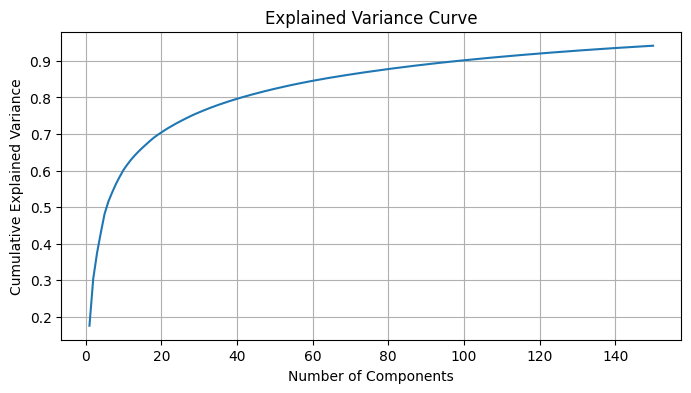

In [9]:
pca_full = PCA(n_components = 150).fit(X_train)
cumulative = np.cumsum(pca_full.explained_variance_ratio_)

plt.figure(figsize = (8, 4))
plt.plot(range(1, 151), cumulative)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance Curve")
plt.grid(True)
plt.show()

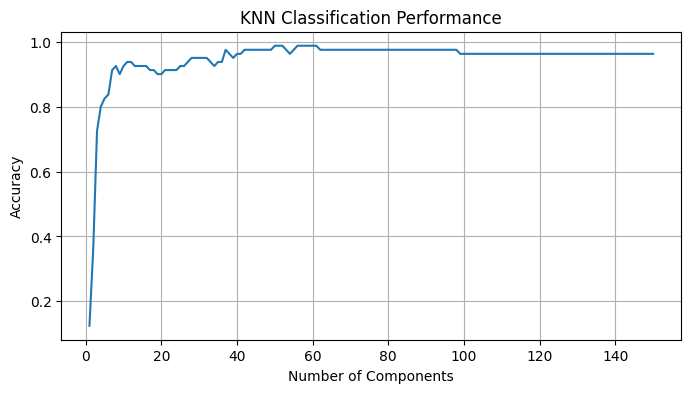

In [10]:
pca_150 = PCA(n_components = 150)
X_train_150 = pca_150.fit_transform(X_train)
X_test_150 = pca_150.transform(X_test)

accuracies = []
for n in range(1, 151):
    knn = KNeighborsClassifier(n_neighbors = 3)
    knn.fit(X_train_150[:, :n], y_train)
    accuracies.append(knn.score(X_test_150[:, :n], y_test))

plt.figure(figsize = (8, 4))
plt.plot(range(1, 151), accuracies)
plt.xlabel("Number of Components")
plt.ylabel("Accuracy")
plt.title("KNN Classification Performance")
plt.grid(True)
plt.show()